# Random forest for binary classification

The first model we'll train is a simple random forest model.\
We'll perform binary classification on Y (with the threshold at Y = 50), and we'll use the following variables:

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)
- weighting the minority class (Y < 50) 3 times as much as the majority class (Y > 50) - roughly the relative frequency of the classes

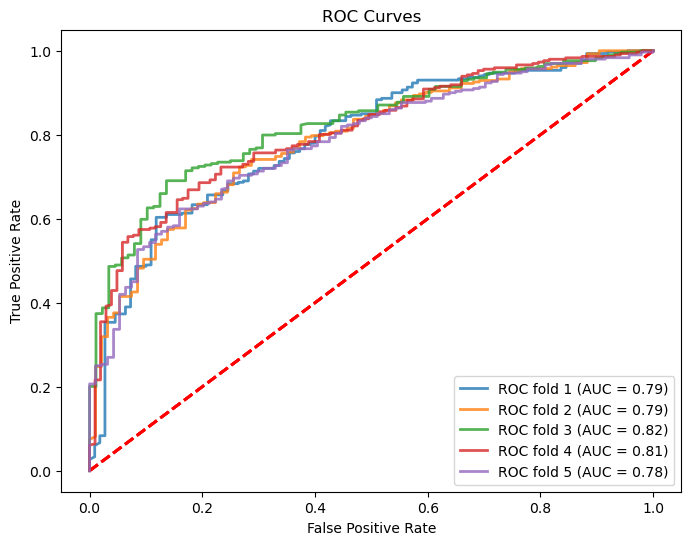

accuracy: 
 0.7379845317864685

precision: 
 0.8727836841305809

recall: 
 0.7621566777372248

f1: 
 0.8136663241598642

auc: 
 0.7993645247208766

confusion_matrix: 
 [[0.66541295 0.33458705]
 [0.23784332 0.76215668]]



In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
rf_y = data["Y_binary"]*1
rf_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
rf_X = pd.get_dummies(rf_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "confusion_matrix": []}

# Perform cross-validation
plt.figure(figsize=(8, 6))

for i in range(5):
    # Split the data into training and testing sets for this fold
    X_train = rf_X.loc[~fold_indices[i], :]
    X_test = rf_X.loc[fold_indices[i], :]
    y_train = rf_y.loc[~fold_indices[i]]
    y_test = rf_y.loc[fold_indices[i]]

    # Train a random forest classifier on the training data for this fold
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=10,
                                 random_state=0,
                                 class_weight={0:3, 1:1})
                              
    clf.fit(X_train, y_train)

    # Predict the labels for the testing data and calculate the metrics for this fold
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred, normalize="true")

    # Store the metrics for this fold in the dictionary
    metrics_dict["accuracy"].append(accuracy)
    metrics_dict["precision"].append(precision)
    metrics_dict["recall"].append(recall)
    metrics_dict["f1"].append(f1)
    metrics_dict["auc"].append(roc_auc)
    metrics_dict["confusion_matrix"].append(cm)

    # Plot the ROC curve for this fold
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=.8)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

# Show all the ROC curves
plt.title(f"ROC Curves")
plt.show()

# Print the metrics
for metric in ["accuracy", "precision", "recall", "f1", "auc", "confusion_matrix"]:
    print(f"{metric}: \n {sum(metrics_dict[metric])/5}\n")

The results seems to be quite satisfying for such a simple model. \
There is a small bias towards classifying the samples as Y > 50, and the true positive rate is also ~10% higher than the true negative rate.

# Simple neural network for classification

The next model we'll train is a simple neural network model.\
We'll perform binary classification on Y (with the threshold at Y = 50), and we'll use the following variables:

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)
- weighting the minority class (Y < 50) 3 times as much as the majority class (Y > 50) - roughly the relative frequency of the classes

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

    
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.droput = nn.Dropout(p=.25)
        

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.droput(x)
        x = self.fc4(x)
        return x
    
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

c:\Users\vesor\Anaconda3\envs\detectron2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


training fold 0


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


evaluation fold 0
accuracy: [0.7170731707317073]
precision: [0.8931623931623932]
recall: [0.6966666666666667]
training fold 1


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


evaluation fold 1
accuracy: [0.7170731707317073, 0.7127659574468085]
precision: [0.8931623931623932, 0.910377358490566]
recall: [0.6966666666666667, 0.6843971631205674]
training fold 2


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


evaluation fold 2
accuracy: [0.7170731707317073, 0.7127659574468085, 0.7198952879581152]
precision: [0.8931623931623932, 0.910377358490566, 0.9155555555555556]
recall: [0.6966666666666667, 0.6843971631205674, 0.7006802721088435]
training fold 3


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


evaluation fold 3
accuracy: [0.7170731707317073, 0.7127659574468085, 0.7198952879581152, 0.7243107769423559]
precision: [0.8931623931623932, 0.910377358490566, 0.9155555555555556, 0.8974358974358975]
recall: [0.6966666666666667, 0.6843971631205674, 0.7006802721088435, 0.7094594594594594]
training fold 4


100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


evaluation fold 4
accuracy: [0.7170731707317073, 0.7127659574468085, 0.7198952879581152, 0.7243107769423559, 0.6954314720812182]
precision: [0.8931623931623932, 0.910377358490566, 0.9155555555555556, 0.8974358974358975, 0.8879310344827587]
recall: [0.6966666666666667, 0.6843971631205674, 0.7006802721088435, 0.7094594594594594, 0.6866666666666666]


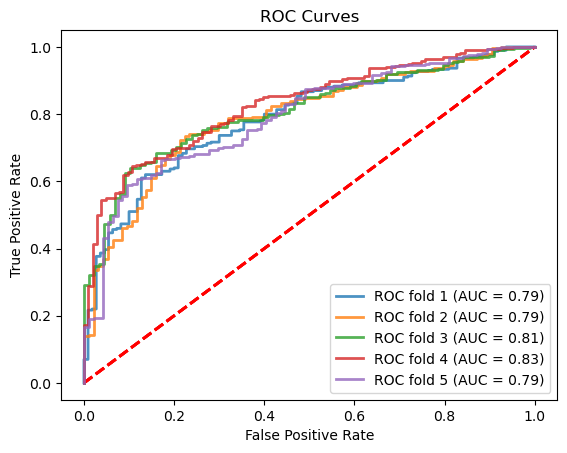

accuracy: 
 0.713895333032041

precision: 
 0.9008924478254341

recall: 
 0.6955740456044408

f1: 
 0.7849742541875722

auc: 
 0.8031145600756956

confusion_matrix: 
 [[0.76901701 0.23098299]
 [0.30442595 0.69557405]]



In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
nn_y = data["Y"]

nn_y = (nn_y > 50).astype(int)

nn_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
nn_X = pd.get_dummies(nn_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"mse": [], "L1": []}

# Define the hyperparameters
learning_rate = 1e-4
n_epochs = 100
batch_size = 32

metrics_dict = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "confusion_matrix": []}

# Perform cross-validation
for i in range(5):

    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Create PyTorch datasets and data loaders
    train_dataset = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = MyDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # Initialize the neural network and optimizer
    net = SimpleNet()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Train the neural network
    print(f"training fold {i}")
    net.train()
    for epoch in tqdm(range(n_epochs)):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = net(X_batch)
            weights = (y_batch-1).abs()*2 + 1
            loss = nn.BCEWithLogitsLoss(weight=weights)(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    
    #Evaluate the neural network on the testing data for this fold
    print(f"evaluation fold {i}")
    net.eval()
    with torch.no_grad():
        for X_batch, y_test in test_loader:
            y_pred_proba = net(X_batch)
            y_pred = nn.Sigmoid()(y_pred_proba)
            y_pred = (y_pred >= 0.5)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred, normalize="true")

    # Store the metrics for this fold in the dictionary
    metrics_dict["accuracy"].append(accuracy)
    metrics_dict["precision"].append(precision)
    metrics_dict["recall"].append(recall)
    metrics_dict["f1"].append(f1)
    metrics_dict["auc"].append(roc_auc)
    metrics_dict["confusion_matrix"].append(cm)

    for key in ["accuracy", "precision", "recall"]:
        print(f"{key}: {metrics_dict[key]}")

    # Plot the ROC curve for this fold
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=.8)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

# Show all the ROC curves
plt.title(f"ROC Curves")
plt.show()

# Print the metrics
for metric in ["accuracy", "precision", "recall", "f1", "auc", "confusion_matrix"]:
    print(f"{metric}: \n {sum(metrics_dict[metric])/5}\n")

The results from this model is quite similar to the ones we got from the random forest model.
* The accuracy is 4 % lower
* The precision is 1 % higher
* The recall is 10 % lower
* The f1 score is 3 % lower
* The true negative rate is 7 % higher
* The true postivie rate is 8 % lower

All in all the choice between these two models in their current form depends on the relative importance between false positives and false negatives for the usecase of the data.

# Random forest regression
We can also use random forest for regression, using the following variables

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- Encoding of the variation of sequences (X2_var_encoding, X3_var_encoding)

I will use it to predict the log transformed Y values, and use 5-fold crossvalidation

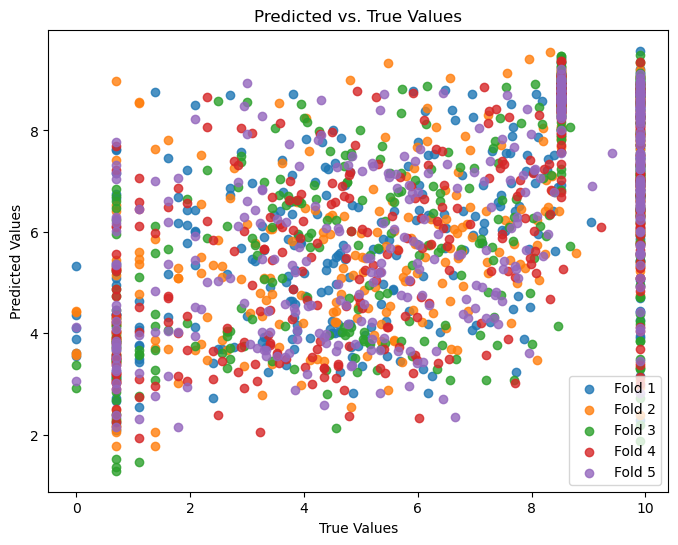

r2: 0.35
mse: 6.19
mae: 1.91


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
rf_y = data["log(Y+1)"]
rf_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
rf_X = pd.get_dummies(rf_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"r2": [], "mse": [], "mae": []}

# Perform cross-validation
plt.figure(figsize=(8, 6))

for i in range(5):
    # Split the data into training and testing sets for this fold
    X_train = rf_X.loc[~fold_indices[i], :]
    X_test = rf_X.loc[fold_indices[i], :]
    y_train = rf_y.loc[~fold_indices[i]]
    y_test = rf_y.loc[fold_indices[i]]

    # Train a random forest regressor on the training data for this fold
    clf = RandomForestRegressor(n_estimators=100,
                                 max_depth=10,
                                 random_state=0)
                              
    clf.fit(X_train, y_train)

    # Predict the labels for the testing data and calculate the metrics for this fold
    y_pred = clf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store the metrics for this fold in the dictionary
    metrics_dict["r2"].append(r2)
    metrics_dict["mse"].append(mse)
    metrics_dict["mae"].append(mae)

    # Plot the predicted vs. true values for this fold
    plt.scatter(y_test, y_pred, alpha=0.8, label=f'Fold {i+1}')

# Show the scatter plot of predicted vs. true values
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend(loc="lower right")
plt.title(f"Predicted vs. True Values")
plt.show()

# Print the metrics
for metric in ["r2", "mse", "mae"]:
    print(f"{metric}: {sum(metrics_dict[metric])/5:.2f}")


This time the results is not impressive. There is a very low correlation between predicted and actual values.

# Simple neural network for regression
The next model will be a simple feed forward neural network using the following variables

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- Encoding of the variation of sequences (X2_var_encoding, X3_var_encoding)
- weighting the datapoints by Y_weights (the inverse frequency of Y values)

I will use it to predict the log transformed Y values, and will train the model on fold 2-5 and evaluate on fold 1.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self,input_dim=13):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.droput = nn.Dropout(p=.3)
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        x = ((nn.Tanh()(x) + 1)/2)*10.
        return x

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y, weights):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
        self.weights = torch.tensor(weights.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

In [ ]:
data = pd.read_json("preprocessed_data.json")

nn_X = data[["PCA1", "PCA2", "X2_var_encoding", "X3_var_encoding"]]

# apply lambda function to create new columns for each value in lists
nn_X[['X2_var_' + str(n) for n in range(nn_X["X2_var_encoding"][0].__len__())]] = nn_X['X2_var_encoding'].apply(lambda x: pd.Series(x))
nn_X[['X3_var_' + str(n) for n in range(nn_X["X3_var_encoding"][0].__len__())]] = nn_X['X3_var_encoding'].apply(lambda x: pd.Series(x))

# drop original columns
nn_X = nn_X.drop(['X2_var_encoding', 'X3_var_encoding'], axis=1)

In [7]:

# Separate the features and labels
nn_y = data["log(Y+1)"]
std = 1
mean = 0

nn_weights = data["Y_weights"]

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]


# Define the hyperparameters
learning_rate = 1e-4
n_epochs = 200
batch_size = 32


# Perform cross-validation
for i in range(1):

    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_train_weights = nn_weights.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]
    y_test_weights = nn_weights.loc[fold_indices[i]]

    # Load the data
    train_data = MyDataset(X_train, y_train, y_train_weights)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = SimpleNet(input_dim=train_data[0][0].shape[0])
    criterion = nn.MSELoss(reduction="none")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, labels, weights in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)*weights
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_data)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")


Epoch 10 loss: 0.6398
Epoch 20 loss: 0.6307
Epoch 30 loss: 0.6134
Epoch 40 loss: 0.6097
Epoch 50 loss: 0.5900
Epoch 60 loss: 0.5988
Epoch 70 loss: 0.5835
Epoch 80 loss: 0.5784
Epoch 90 loss: 0.5760
Epoch 100 loss: 0.5730
Epoch 110 loss: 0.5686
Epoch 120 loss: 0.5643
Epoch 130 loss: 0.5615
Epoch 140 loss: 0.5730
Epoch 150 loss: 0.5624
Epoch 160 loss: 0.5524
Epoch 170 loss: 0.5519
Epoch 180 loss: 0.5475
Epoch 190 loss: 0.5480
Epoch 200 loss: 0.5378


In [8]:
# Iterate over the test data
test_data = MyDataset(X_test, y_test, y_test_weights)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

model.eval()
with torch.no_grad():
    for inputs, y, y_test_weights in test_loader:
        outputs = model(inputs)


# # Calculate evaluation metrics
mse = nn.MSELoss(reduction="none")(y*std + mean, outputs*std + mean)
L1 = nn.L1Loss(reduction="none")(y*std + mean, outputs*std + mean)

# Print the evaluation results
print(f"Mean Squared Error (MSE): {mse.mean():.4f}")
print(f"Mean Absolute Error (L1): {L1.mean():.4f}")

Mean Squared Error (MSE): 8.8249
Mean Absolute Error (L1): 2.6037


In [9]:
# Unnormalize target and prediction
unorm_y = y*std + mean
unorm_pred = outputs*std + mean

# Undo the log transform
Y = np.exp(unorm_y)-1
pred_Y = np.exp(unorm_pred)-1
error = Y - pred_Y

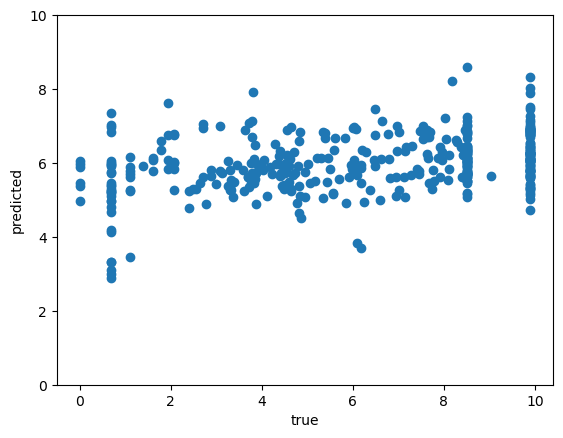

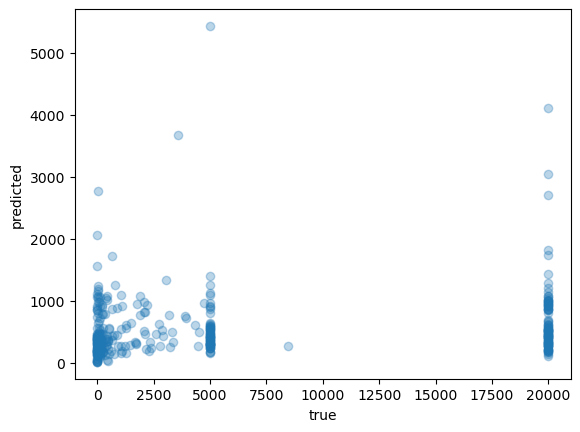

In [10]:
# Plot the true versus predicted values
plt.scatter(unorm_y, unorm_pred)
plt.xlabel("true");
plt.ylabel("predicted");
plt.ylim([0,10])
plt.show()

# Plot the untransformed true versus predicted values 
plt.scatter(Y, pred_Y, alpha=0.3)
plt.xlabel("true");
plt.ylabel("predicted");
plt.show()

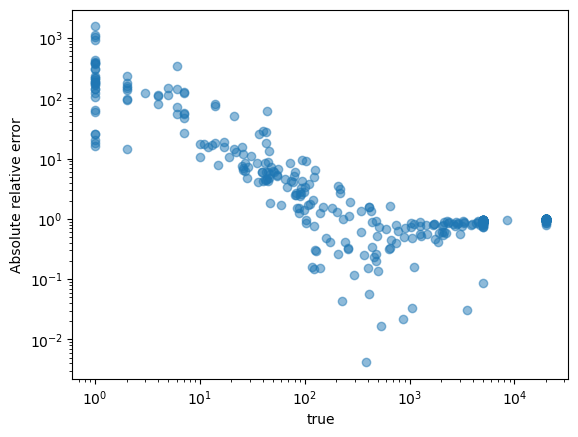

In [11]:
# Plot the absolute relative error versus true values
plt.scatter(Y, abs(error)/Y, alpha=0.5)
plt.loglog()
plt.xlabel("true");
plt.ylabel("Absolute relative error");

The results from the neural network regression is as little impressive as the ones from the random forest model.\
The network seems to always predict some mean value of the dataset - overestimating datapoints for small Y and underestimating the ones for large Y. \

# Fancy neural network for regression

Lets see if we can get some better results by using a more fancy network with increased learning capacity.\

The next model will be a transformer based neural network using the following variables

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)
- Downsampling of datapoints with Y = 1, 5000, 20 000 - to see if we can get a good model by majority downsampling. \
Since we perform downsampling I will no longer use weighting of costfunction

I will use it to predict the log transformed Y values, and will train the model on fold 2-5 and evaluate on fold 1.

In [12]:
# Define the neural network

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads):
        super().__init__()
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim), 
            num_layers=num_layers
        )
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        x = 10*(nn.Tanh()(x)+1)/2
        return x
    
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
# Load the data
data = pd.read_json("preprocessed_data.json")

# Identify indices where Y is equal to 5000 or 20000
indices_to_downsample = data[data["Y"].isin([1, 5000., 20000.])].index

# Randomly select a subset of indices to downsample
downsampling_ratio = 0.95
num_samples = 1000
selected_indices = np.random.choice(indices_to_downsample, size=int(len(indices_to_downsample) * downsampling_ratio), replace=False)

# Subset your dataframe using the selected indices
data_downsampled = data.drop(selected_indices)

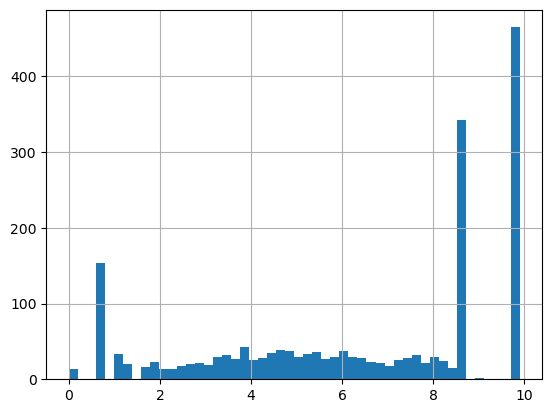

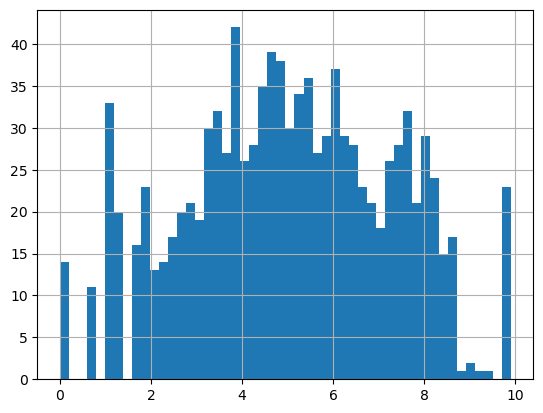

In [14]:
# Show the distribution of logY values before and after downsampling

data["log(Y+1)"].hist(bins=50);
plt.show()
data_downsampled["log(Y+1)"].hist(bins=50);
plt.show()

In [15]:
data = data_downsampled.copy()

# Separate the features and labels
nn_y = data["log(Y+1)"]

mean = nn_y.mean()
std = nn_y.std()

mean = 0
std = 1

nn_y = (nn_y - mean)/std

nn_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
nn_X = pd.get_dummies(nn_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]


# Define the hyperparameters
input_dim = 13
output_dim = 1
hidden_dim = 256
num_layers = 8
num_heads = 13

learning_rate = 1e-4
n_epochs = 200
batch_size = 32


# Perform cross-validation
for i in range(1):

    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Load the data
    train_data = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = TransformerRegressor(input_dim, output_dim, hidden_dim, num_layers, num_heads)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_data)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")


Epoch 5 loss: 5.3417
Epoch 10 loss: 5.0985
Epoch 15 loss: 5.0514
Epoch 20 loss: 4.9658
Epoch 25 loss: 4.7498
Epoch 30 loss: 4.5904
Epoch 35 loss: 4.4440
Epoch 40 loss: 4.3765
Epoch 45 loss: 4.3683
Epoch 50 loss: 4.2881
Epoch 55 loss: 4.3261
Epoch 60 loss: 4.1783
Epoch 65 loss: 4.1606
Epoch 70 loss: 4.0866
Epoch 75 loss: 4.1365
Epoch 80 loss: 4.1235
Epoch 85 loss: 4.0371
Epoch 90 loss: 4.0624
Epoch 95 loss: 3.9655
Epoch 100 loss: 3.9322
Epoch 105 loss: 3.8855
Epoch 110 loss: 4.0044
Epoch 115 loss: 3.9332
Epoch 120 loss: 3.8938
Epoch 125 loss: 3.9282
Epoch 130 loss: 3.9542
Epoch 135 loss: 3.9477
Epoch 140 loss: 3.7824
Epoch 145 loss: 3.8298
Epoch 150 loss: 3.8351
Epoch 155 loss: 3.8223
Epoch 160 loss: 3.7644
Epoch 165 loss: 3.8824
Epoch 170 loss: 3.7892
Epoch 175 loss: 3.8545
Epoch 180 loss: 3.7687
Epoch 185 loss: 3.7574
Epoch 190 loss: 3.8171
Epoch 195 loss: 3.7129
Epoch 200 loss: 3.7389


In [16]:
# Iterate over the test data
test_data = MyDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

model.eval()
with torch.no_grad():
    for inputs, y in test_loader:
        outputs = model(inputs)


# Calculate evaluation metrics
unorm_y = y*std + mean
unorm_pred = outputs*std + mean

mse = nn.MSELoss(reduction="none")(unorm_y, unorm_pred)
L1 = nn.L1Loss(reduction="none")(unorm_y, unorm_pred)

# Print the evaluation results
print(f"Mean Squared Error (MSE): {mse.mean():.4f}")
print(f"Mean Absolute Error (L1): {L1.mean():.4f}")

Mean Squared Error (MSE): 4.2469
Mean Absolute Error (L1): 1.6718


In [17]:
# Unnormalize target and prediction
unorm_y = y*std + mean
unorm_pred = outputs*std + mean

# Undo the log transform
Y = np.exp(unorm_y)-1
pred_Y = np.exp(unorm_pred)-1
error = Y - pred_Y

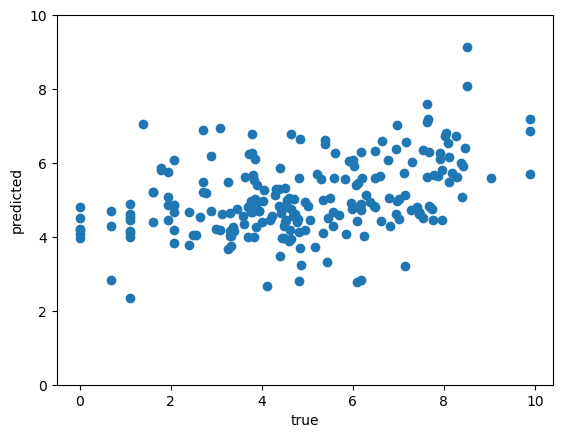

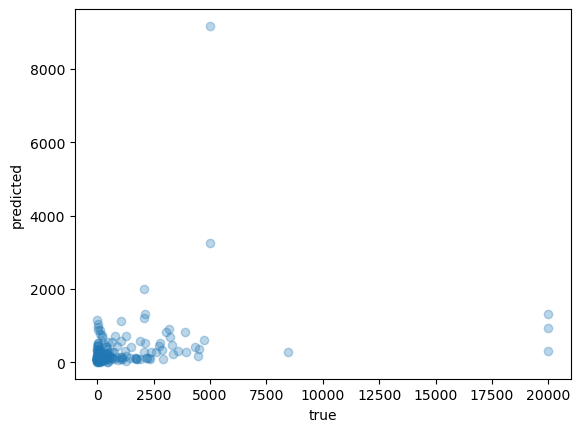

In [18]:
# Plot the true versus predicted values
plt.scatter(unorm_y, unorm_pred)
plt.xlabel("true");
plt.ylabel("predicted");
plt.ylim([0,10])
plt.show()

# Plot the untransformed true versus predicted values 
plt.scatter(Y, pred_Y, alpha=0.3)
plt.xlabel("true");
plt.ylabel("predicted");
plt.show()

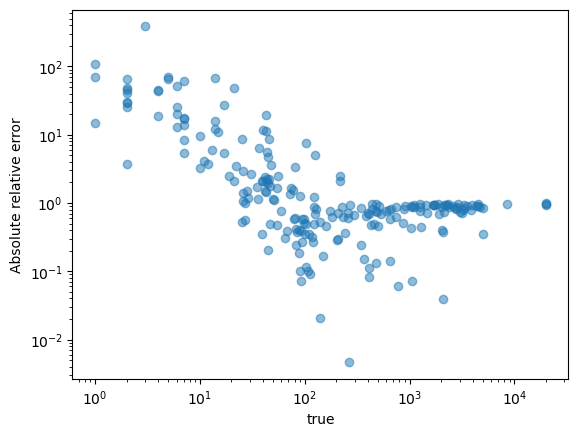

In [19]:
# Plot the absolute relative error versus true values
plt.scatter(Y, abs(error)/Y, alpha=0.5)
plt.loglog()
plt.xlabel("true");
plt.ylabel("Absolute relative error");

While this model have reduced MSE error and absolute error compared to the previous models, that is probably just due to the downsampling.

# Neural network for multiclass classification

Since none of the regression models was able to suitably estimate the data, the final model will be a multiclass model. \
The motiviation here is that the regression performed terribly, while the binary classification showed more promise - so lets make a model that strikes a balance between the two.\


I will bin the values of Y in for approximately equal sized bins (in terms of population): ["0-50", "50-4000", "4000-6000", "6000+"] and use the following variables:

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)

The goal is to predict which of the 4 bins the data came from. I will train the model on fold 2-5 and evaluate on fold 1.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the neural network
# Define the classification model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the bin labels
bins = [-np.inf, 50, 4000, 6000, 30000]
bin_labels = [0, 1, 2, 3]  # one label for each bin

# Load the data
data = pd.read_json("preprocessed_data.json")

# Create the bin labels for each sample
nn_y = pd.cut(data["Y"], bins=bins, labels=bin_labels)

nn_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
nn_X = pd.get_dummies(nn_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]


# Define the hyperparameters
learning_rate = 1e-4
n_epochs = 200
batch_size = 32


# Perform cross-validation
for i in range(1):

    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Load the data
    train_data = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = SimpleClassifier(input_dim=train_data[0][0].shape[0])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_data)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

Epoch 10 loss: 0.9862
Epoch 20 loss: 0.9303
Epoch 30 loss: 0.9144
Epoch 40 loss: 0.9044
Epoch 50 loss: 0.8964
Epoch 60 loss: 0.8907
Epoch 70 loss: 0.8845
Epoch 80 loss: 0.8801
Epoch 90 loss: 0.8760
Epoch 100 loss: 0.8719
Epoch 110 loss: 0.8679
Epoch 120 loss: 0.8643
Epoch 130 loss: 0.8614
Epoch 140 loss: 0.8578
Epoch 150 loss: 0.8558
Epoch 160 loss: 0.8526
Epoch 170 loss: 0.8503
Epoch 180 loss: 0.8485
Epoch 190 loss: 0.8456
Epoch 200 loss: 0.8429


Confusion matrix:
[[0.35 0.55 0.03 0.08]
 [0.21 0.63 0.02 0.13]
 [0.   0.04 0.93 0.03]
 [0.05 0.35 0.31 0.3 ]]


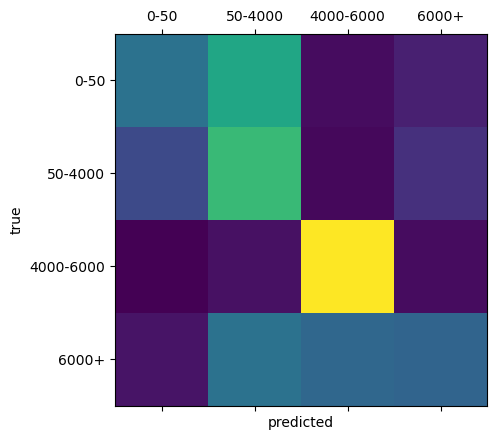

In [22]:
from sklearn.metrics import confusion_matrix

test_data = MyDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_loader), shuffle=False)

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())

# Convert the predictions and ground truth to numpy arrays
y_pred = np.array(y_pred)
y_true = y_test.values

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")

# Print the confusion matrix
print("Confusion matrix:")
print(cm.round(2))
plt.matshow(cm.round(2))
plt.ylabel("true")
plt.xlabel("predicted")

bin_names = ["0-50", "50-4000", "4000-6000", "6000+"]
bin_names = ["0-50", "50-4000", "4000-6000", "6000+"]
plt.xticks(ticks=[0,1,2,3], labels=bin_names);
plt.yticks(ticks=[0,1,2,3], labels=bin_names);

We observe the following from studying the confusion matrix: 
* the model performs well at predicting the datapoints between 4000-6000.
* the model struggles with separating datapoints from the first two bins - but does not confuse them with the two other bins
* the model does not often misclassify 6000+ points as points from the 0-50 bin, but it does not perform better than random guess between the other bins.

# Summary

### **What can you say about the data?**
* The Y values seems to follow a 1/x or log-normal distribution, with deviation from the distrubtion with high counts at Y = 5000 and Y = 20 000.
* The points with Y = 20 000 represents about 23% of the data, while Y = 5000 represents about 17%
* The variables X4 and X5 are highly correlated (0.97), and also moderate negtively correlated with X6 (-0.5 and -0.6)
* There are 10 unqiue sequences in X2, with variation in 12 of the sequence positions
* There are 9 unqiue sequences in X3, with variation in 16 of the sequence positions
* The sequences in X2 and X3 are highly correlated and comes paired in 11 unique pairs (out of 90 possible pairs)


### **Which models did you use to predict and why?**

We have trained 3 different models:
* Two for binary classification (Random Forest and Linear Neural Network)
* Three for regression (Random Forest, Linear Neural Network, Transformer Network)
* One for multiclass classification (Linear Neural Net)

### **Explain briefly some pros and cons about the models you used.**

Random Forest: 
* Pros - can handle non-linear relationships and complex interactions, is interpretable. 
* Cons - may overfit the training data, may not generalize well on unseen data.

Linear Neural Network:
* Pros - fast to train, can generalize well on unseen data, can model non-linear relationships.
* Cons - may not capture complex interactions, may not perform well on highly non-linear data.

Transformer Network: 
* Pros - state-of-the-art performance on various tasks, can model long-range dependencies. 
* Cons - requires large amounts of data and computational resources to train, may overfit the training data.

### **How did you validate your models?**
We used cross-validation to validate our models. \
For regression tasks, we used mean squared error (MSE) and mean absolute error (MAE) as evaluation metrics.\
For classification tasks, we used accuracy, precision, recall, f1, auc and confusion matrix.

### **How did you decide which model is the best to use?**

Based on the poor results obtained from the regression models, the better model would be either the binary classification or multiclass classification models. 

The final choice between which classification model to use depends on the specific needs and constraints of the problem at hand. If the binary classification is good enough for the application of the model that model would be a good choice - but if more fine-grained classification is needed the model with multiple classes would be better. Other factors that should be considered when chosing the best model would be:

* trade-off between false positives and false negatives
* the interpretability of the model
* the resources available for fine-tuning the model's hyperparameters.

For example, if the problem at hand requires high precision and minimizing false positives is important, a Linear Neural Network or a Transformer Network may be a good choice. If interpretability is a priority, then a Random Forest may be preferred. Finally, if computational resources are limited, a simpler model like a Linear Neural Network may be a better option than a more complex model like a Transformer Network that requires more training data and computational power.

It's important to note that the models were not fine-tuned, and as such, there may be room for improvement in their performance. Hyperparameter tuning, regularization, and feature engineering are all techniques that can be used to improve model performance - especially for the neural networks.